In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from kdelearn.kde_tasks import KDEOutliersDetection
from kdelearn.metrics import pi_kf
from kdelearn.bandwidth_selection import direct_plugin
from sklearn.neighbors import NearestNeighbors

In [2]:
data = pd.read_csv("/home/krystian/Downloads/archive/thyroidDF.csv")

In [3]:
data.shape

(9172, 31)

In [4]:
data.columns

Index(['age', 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_meds', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'TSH',
       'T3_measured', 'T3', 'TT4_measured', 'TT4', 'T4U_measured', 'T4U',
       'FTI_measured', 'FTI', 'TBG_measured', 'TBG', 'referral_source',
       'target', 'patient_id'],
      dtype='object')

In [5]:
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target,patient_id
0,29,F,f,f,f,f,f,f,f,t,...,NaN,f,NaN,f,NaN,f,NaN,other,-,840801013
1,29,F,f,f,f,f,f,f,f,f,...,128.0,f,NaN,f,NaN,f,NaN,other,-,840801014
2,41,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,11.0,other,-,840801042
3,36,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,26.0,other,-,840803046
4,32,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,36.0,other,S,840803047


In [6]:
data["target"].value_counts()

-      6771
K       436
G       359
I       346
F       233
R       196
A       147
L       115
M       111
N       110
S        85
GK       49
AK       46
J        30
B        21
MK       16
Q        14
O        14
C|I      12
KJ       11
GI       10
H|K       8
D         8
FK        6
C         6
P         5
MI        2
LJ        1
GKJ       1
OI        1
D|R       1
E         1
Name: target, dtype: int64

In [7]:
# 	hypothyroid conditions:

# 		E	hypothyroid
# 		F	primary hypothyroid
# 		G	compensated hypothyroid
# 		H	secondary hypothyroid

In [8]:
data["age"].isna().sum(), data["TSH"].isna().sum(), data["T3"].isna().sum(), data["TT4"].isna().sum(), data["T4U"].isna().sum(), data["FTI"].isna().sum(), data["TBG"].isna().sum()

(0, 842, 2604, 442, 809, 802, 8823)

In [9]:
data = data[(data["age"] > 0) & (data["age"] < 101)]
data = data[data["target"].isin(["-", "G", "F"])]
data.loc[data["target"]=="-", "target"] = 0
data.loc[data["target"]=="G", "target"] = 1
data.loc[data["target"]=="F", "target"] = 2
data["target"] = data["target"].astype(int)
data = data.reset_index(drop=True)

data.shape

(7359, 31)

In [10]:
data = data[["age", "TSH", "T3", "TT4", "T4U", "FTI", "target"]].dropna()

In [11]:
data.shape

(4683, 7)

In [12]:
data["target"].value_counts()

0    4293
1     221
2     169
Name: target, dtype: int64

# EDA 1d

## age

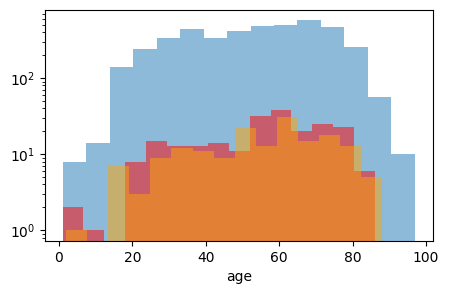

In [13]:
plt.figure(figsize=(5, 3))
plt.hist(data.loc[data["target"] == 0, "age"], bins=15, alpha=0.5)
plt.hist(data.loc[data["target"] == 1, "age"], bins=15, alpha=0.5, color="red")
plt.hist(data.loc[data["target"] == 2, "age"], bins=15, alpha=0.5, color="orange")
plt.yscale("log")
plt.xlabel("age")
plt.show()

## TSH

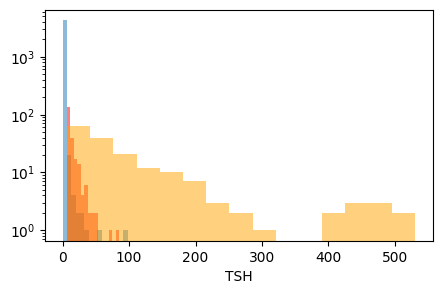

In [14]:
plt.figure(figsize=(5, 3))
plt.hist(data.loc[data["target"] == 0, "TSH"], bins=15, alpha=0.5)
plt.hist(data.loc[data["target"] == 1, "TSH"], bins=15, alpha=0.5, color="red")
plt.hist(data.loc[data["target"] == 2, "TSH"], bins=15, alpha=0.5, color="orange")
plt.yscale("log")
plt.xlabel("TSH")
plt.show()

## T3

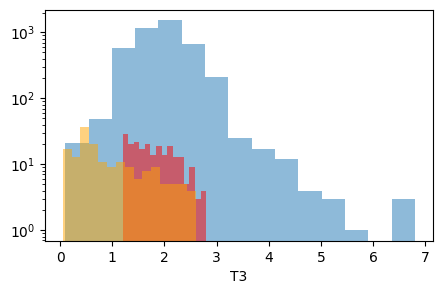

In [15]:
plt.figure(figsize=(5, 3))
plt.hist(data.loc[data["target"] == 0, "T3"], bins=15, alpha=0.5)
plt.hist(data.loc[data["target"] == 1, "T3"], bins=15, alpha=0.5, color="red")
plt.hist(data.loc[data["target"] == 2, "T3"], bins=15, alpha=0.5, color="orange")
plt.yscale("log")
plt.xlabel("T3")
plt.show()

## TT4

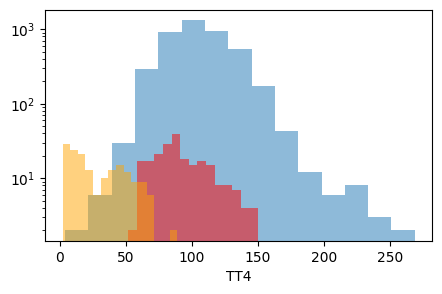

In [16]:
plt.figure(figsize=(5, 3))
plt.hist(data.loc[data["target"] == 0, "TT4"], bins=15, alpha=0.5)
plt.hist(data.loc[data["target"] == 1, "TT4"], bins=15, alpha=0.5, color="red")
plt.hist(data.loc[data["target"] == 2, "TT4"], bins=15, alpha=0.5, color="orange")
plt.yscale("log")
plt.xlabel("TT4")
plt.show()

## T4U

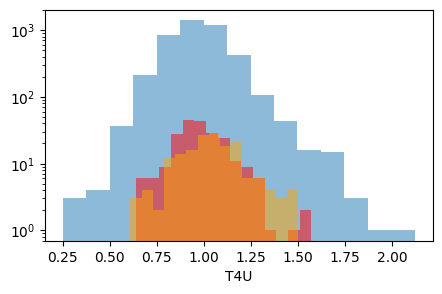

In [17]:
plt.figure(figsize=(5, 3))
plt.hist(data.loc[data["target"] == 0, "T4U"], bins=15, alpha=0.5)
plt.hist(data.loc[data["target"] == 1, "T4U"], bins=15, alpha=0.5, color="red")
plt.hist(data.loc[data["target"] == 2, "T4U"], bins=15, alpha=0.5, color="orange")
plt.yscale("log")
plt.xlabel("T4U")
plt.show()

## FTI

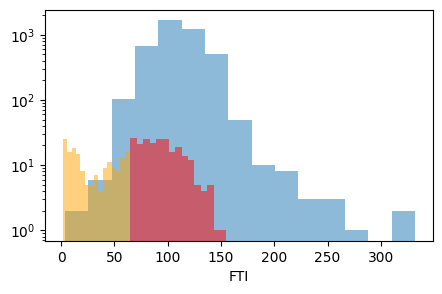

In [18]:
plt.figure(figsize=(5, 3))
plt.hist(data.loc[data["target"] == 0, "FTI"], bins=15, alpha=0.5)
plt.hist(data.loc[data["target"] == 1, "FTI"], bins=15, alpha=0.5, color="red")
plt.hist(data.loc[data["target"] == 2, "FTI"], bins=15, alpha=0.5, color="orange")
plt.yscale("log")
plt.xlabel("FTI")
plt.show()

\newpage

# Outliers detection

In [19]:
data_all = data[["age", "TSH", "T3", "TT4", "T4U", "FTI", "target"]].copy()
data_all.loc[data_all["target"]!=0, "target"] = 1

x_train = data_all[["age", "TSH", "T3", "TT4", "T4U", "FTI"]].to_numpy().copy()
labels_train = data_all["target"].to_numpy().copy()

In [20]:
bandwidth = direct_plugin(x_train)

## Siatka po k (przy r=0.083)
[5, 10, 20, 50, 100, 200, 500, 1000]

In [32]:
k_grid = np.array([5, 10, 20, 50, 100, 200, 500, 1000])
metrics = []

for k in k_grid:
    print(f"k: {k}")
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='brute').fit(x_train)
    distances, indices = nbrs.kneighbors(x_train)
    dist_k = np.max(distances, axis=1)
    r = 0.083
    threshold = np.quantile(dist_k, 1 - r)
    labels_pred = np.where(dist_k >= threshold, 1 ,0)
    metric = pi_kf(x_train, labels_pred, bandwidth=bandwidth)
    metrics.append(metric)
    print(f"Wskaznik jakosci: {metric}")

    res = confusion_matrix(labels_train, labels_pred)
    print(res)

    print(f"precision: {res[1, 1] / res[:, 1].sum()}")
    print(f"recall: {res[1, 1] / res[1, :].sum()}")
    print(f"accuracy: {np.diag(res).sum() / res.sum()}")

    print("-"*30)

k: 5
Wskaznik jakosci: 1.0019809883222528
[[4117  176]
 [ 177  213]]
precision: 0.5475578406169666
recall: 0.5461538461538461
accuracy: 0.9246209694640188
------------------------------
k: 10
Wskaznik jakosci: 1.0019501583904613
[[4118  175]
 [ 176  214]]
precision: 0.5501285347043702
recall: 0.5487179487179488
accuracy: 0.9250480461242793
------------------------------
k: 20
Wskaznik jakosci: 1.0019266475937942
[[4110  183]
 [ 184  206]]
precision: 0.5295629820051414
recall: 0.5282051282051282
accuracy: 0.9216314328421952
------------------------------
k: 50
Wskaznik jakosci: 1.002139693254627
[[4098  195]
 [ 196  194]]
precision: 0.4987146529562982
recall: 0.49743589743589745
accuracy: 0.9165065129190689
------------------------------
k: 100
Wskaznik jakosci: 1.0021934938424137
[[4094  199]
 [ 200  190]]
precision: 0.4884318766066838
recall: 0.48717948717948717
accuracy: 0.9147982062780269
------------------------------
k: 200
Wskaznik jakosci: 1.0031056072320297
[[4087  206]
 [ 207 

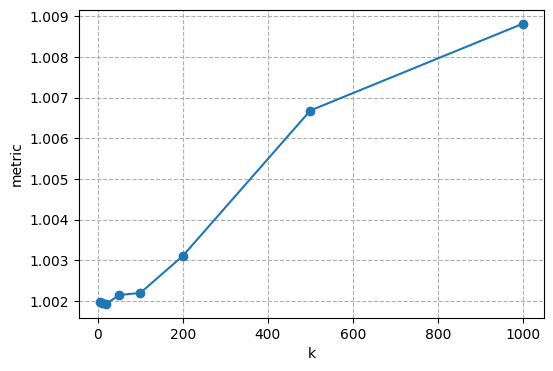

In [33]:
plt.figure(figsize=(6, 4))

plt.plot(k_grid, metrics, "-o")

plt.xlabel("k")
plt.ylabel("metric")
plt.grid(linestyle="--")
plt.show()

\newpage

## Siatka po r (przy k=10)

Siatka od 0.01 do 0.5 z krokiem 0.01

In [35]:
r_grid = np.arange(0.01, 0.51, 0.01)
metrics = []

for r in r_grid:
    print(f"r: {r:.2f}")
    nbrs = NearestNeighbors(n_neighbors=11, algorithm='brute').fit(x_train)
    distances, indices = nbrs.kneighbors(x_train)
    dist_k = np.max(distances, axis=1)
    threshold = np.quantile(dist_k, 1 - r)
    labels_pred = np.where(dist_k >= threshold, 1 ,0)
    metric = pi_kf(x_train, labels_pred, bandwidth=bandwidth)
    metrics.append(metric)
    print(f"Wskaznik jakosci: {metric}")

    res = confusion_matrix(labels_train, labels_pred)
    print(res)

    print(f"precision: {res[1, 1] / res[:, 1].sum()}")
    print(f"recall: {res[1, 1] / res[1, :].sum()}")
    print(f"accuracy: {np.diag(res).sum() / res.sum()}")

    print("-"*30)

r: 0.01
Wskaznik jakosci: 1.0000000317386704
[[4273   20]
 [ 363   27]]
precision: 0.574468085106383
recall: 0.06923076923076923
accuracy: 0.9182148195601111
------------------------------
r: 0.02
Wskaznik jakosci: 1.000011730019369
[[4255   38]
 [ 334   56]]
precision: 0.5957446808510638
recall: 0.14358974358974358
accuracy: 0.9205637411915438
------------------------------
r: 0.03
Wskaznik jakosci: 1.0001764554877703
[[4242   51]
 [ 299   91]]
precision: 0.6408450704225352
recall: 0.23333333333333334
accuracy: 0.9252615844544095
------------------------------
r: 0.04
Wskaznik jakosci: 1.0004215022296923
[[4225   68]
 [ 270  120]]
precision: 0.6382978723404256
recall: 0.3076923076923077
accuracy: 0.9278240444159727
------------------------------
r: 0.05
Wskaznik jakosci: 1.0005503588804356
[[4208   85]
 [ 240  150]]
precision: 0.6382978723404256
recall: 0.38461538461538464
accuracy: 0.930600042707666
------------------------------
r: 0.06
Wskaznik jakosci: 1.000764794341005
[[4183  11

Wskaznik jakosci: 0.8557542589036043
[[2563 1730]
 [  13  377]]
precision: 0.17892738490745136
recall: 0.9666666666666667
accuracy: 0.6278026905829597
------------------------------
r: 0.46
Wskaznik jakosci: 0.8408792685146379
[[2518 1775]
 [  11  379]]
precision: 0.17595171773444754
recall: 0.9717948717948718
accuracy: 0.6186205423873585
------------------------------
r: 0.47
Wskaznik jakosci: 0.8262081268028034
[[2474 1819]
 [   8  382]]
precision: 0.17355747387551113
recall: 0.9794871794871794
accuracy: 0.6098654708520179
------------------------------
r: 0.48
Wskaznik jakosci: 0.8110719537402169
[[2429 1864]
 [   6  384]]
precision: 0.1708185053380783
recall: 0.9846153846153847
accuracy: 0.6006833226564168
------------------------------
r: 0.49
Wskaznik jakosci: 0.7912798155133381
[[2382 1911]
 [   6  384]]
precision: 0.16732026143790849
recall: 0.9846153846153847
accuracy: 0.5906470211402947
------------------------------
r: 0.50
Wskaznik jakosci: 0.765141334994419
[[2335 1958]
 [

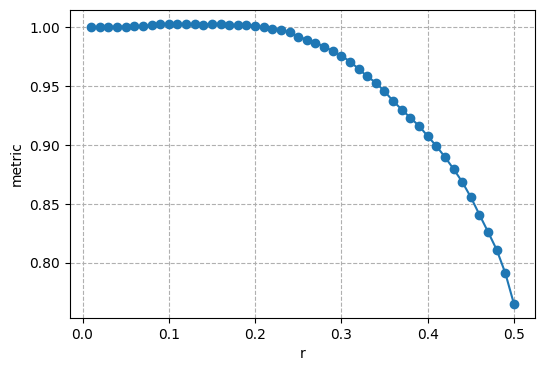

In [36]:
plt.figure(figsize=(6, 4))

plt.plot(r_grid, metrics, "-o")

plt.xlabel("r")
plt.ylabel("metric")
plt.grid(linestyle="--")
plt.show()

\newpage

## Siatka po k oraz r

In [37]:
best_metric = np.inf
for k in k_grid:
    for r in r_grid:
        nbrs = NearestNeighbors(n_neighbors=k, algorithm='brute').fit(x_train)
        distances, indices = nbrs.kneighbors(x_train)
        dist_k = np.max(distances, axis=1)
        threshold = np.quantile(dist_k, 1 - r)
        labels_pred = np.where(dist_k >= threshold, 1 ,0)
        metric = pi_kf(x_train, labels_pred, bandwidth=bandwidth)
    
        if metric < best_metric:
            best_k = k
            best_r = r
            best_metric = metric

print(f"Najlepsze k: {best_k:.2f} oraz r {best_r:.2f}")
print(f"Przy wskaźniku jakości: {best_metric:.6f}")

Najlepsze k: 5.00 oraz r 0.50
Przy wskaźniku jakości: 0.761907


In [38]:
nbrs = NearestNeighbors(n_neighbors=best_k, algorithm='brute').fit(x_train)
distances, indices = nbrs.kneighbors(x_train)
dist_k = np.max(distances, axis=1)
threshold = np.quantile(dist_k, 1 - best_r)
labels_pred = np.where(dist_k >= threshold, 1 ,0)
res = confusion_matrix(labels_train, labels_pred)
print(res)

print(f"precision: {res[1, 1] / res[:, 1].sum()}")
print(f"recall: {res[1, 1] / res[1, :].sum()}")
print(f"accuracy: {np.diag(res).sum() / res.sum()}")

[[2332 1961]
 [   9  381]]
precision: 0.16268146883005977
recall: 0.9769230769230769
accuracy: 0.579329489643391
